In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import pandas as pd
import networkx as nx
import numpy as np
import sys
import seaborn as sns

In [6]:
results_folder = 'mmvec_major_taxa'
results_base_name = 'latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95'

# Input data

In [7]:
table = pd.read_table(results_folder + '/' + results_base_name + '_ranks.txt', index_col=0)
table.head()

,Propionibacteriaceae,Staphylococcus caprae or capitis,Staphylococcus epidermidis,Staphylococcus hominis,Other Staphylococci,Polyomavirus HPyV6,Polyomavirus HPyV7,Merkel Cell Polyomavirus,Malasseziaceae,Corynebacteriaceae,Micrococcaceae,Other families
featureid,,,,,,,,,,,,
X940001,0.177989,0.154912,0.095406,0.012139,0.145922,0.043939,-0.043831,0.105463,0.016188,0.313228,0.165941,0.045453
X940002,0.006612,-0.042924,-0.242801,-0.026591,-0.004430,-0.062433,-0.163995,-0.130395,0.064656,-0.058323,-0.115458,-0.112474
X940005,-0.029823,-0.143696,-0.292455,-0.234061,0.057963,0.406687,-0.044387,-0.068616,0.037003,-0.125615,-0.106984,-0.063329
X940007,0.461745,0.421363,0.296187,0.570376,0.372838,0.035342,0.238131,0.304312,0.476247,0.427392,0.348371,0.321372
X940010,0.408488,0.030971,0.778209,0.523698,0.344422,0.420056,0.744065,0.699084,0.151153,0.408506,0.632428,0.631959


Read microbiome metadata: Not needed as the taxon names are the column headers

Read metabolite metadata: Not needed as we are working with molecular families

# Check stats

There seams to be a local minimum of the model fit where all metabolites have (nearly) identical log conditional probabilities for every microbe.

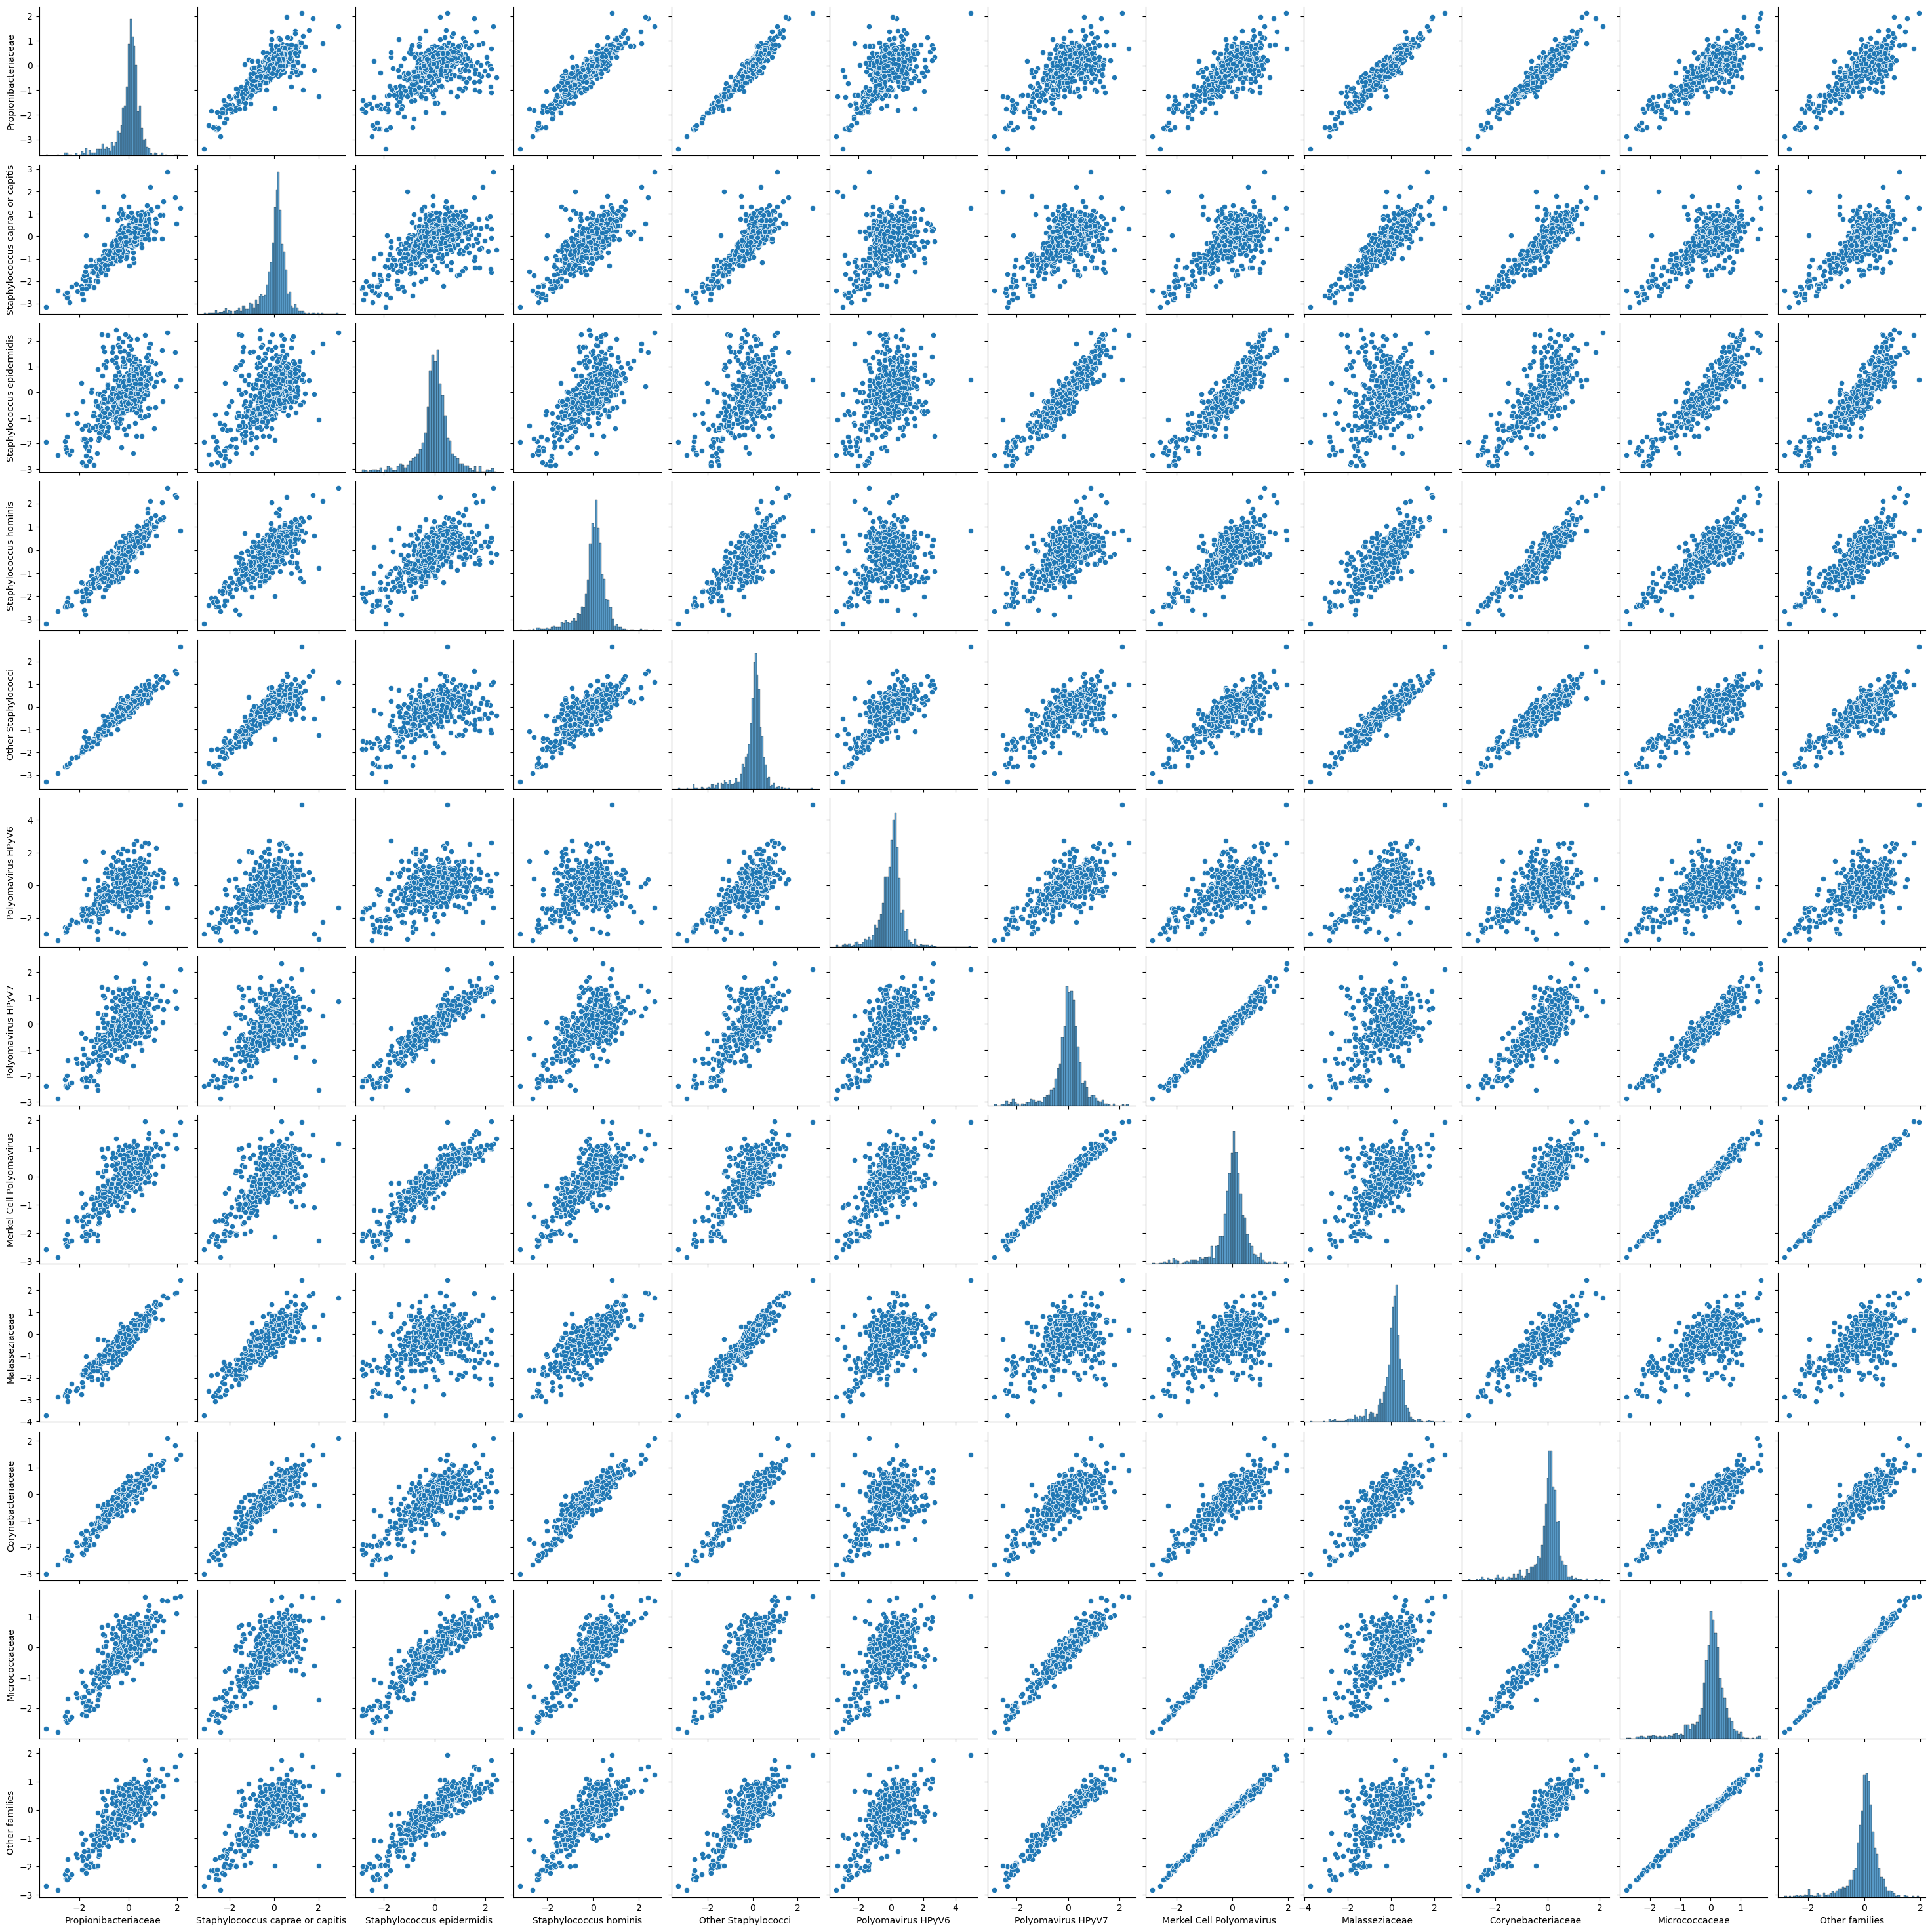

In [8]:
sns.pairplot(table)

The local density of this plot could be calculated with np.histogram:
https://stackoverflow.com/questions/33967513/creating-density-estimate-in-numpy
https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work

Because the data is m-dimensional (m = # microbes), we need np.histogramdd:
https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html

Alternatively, one could use an m-dimensional (m = # microbes) Hotelling ellipsoid at 95% cutoff:
https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

# Transform data

Transform into wide format and rank the results:

In [9]:
longform_pairwise = table.unstack().to_frame('interactionLogCondProb')
longform_pairwise['interactionLogCondProb_abs'] = abs(longform_pairwise['interactionLogCondProb'])
longform_pairwise['interactionLogCondProb_sign'] = np.where(longform_pairwise['interactionLogCondProb'] > 0, 
                                                                 'positive', 'negative')
longform_pairwise.sort_values('interactionLogCondProb_abs', ascending=False, inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.head()

,index,level_0,featureid,interactionLogCondProb,interactionLogCondProb_abs,interactionLogCondProb_sign
0,0,Polyomavirus HPyV6,X970121,4.918287,4.918287,positive
1,1,Malasseziaceae,X960309,-3.727428,3.727428,negative
2,2,Polyomavirus HPyV6,X960683,-3.379084,3.379084,negative
3,3,Propionibacteriaceae,X960309,-3.371261,3.371261,negative
4,4,Other Staphylococci,X960309,-3.316077,3.316077,negative


# Graph

In [10]:
G = nx.Graph()
G = nx.from_pandas_edgelist(longform_pairwise, 'level_0', 'featureid',
                            edge_attr=['index', 'interactionLogCondProb', 'interactionLogCondProb_abs', 'interactionLogCondProb_sign'])
nx.info(G)

/tmp/ipykernel_1161/2291082867.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 1237 nodes and 14700 edges'

Add node_type as node attribute

In [11]:
microbe_metadata = pd.DataFrame(index = table.columns.values)
microbe_metadata['node_type'] = 'microbe' 
microbe_metadata.head()

,node_type
Propionibacteriaceae,microbe
Staphylococcus caprae or capitis,microbe
Staphylococcus epidermidis,microbe
Staphylococcus hominis,microbe
Other Staphylococci,microbe


In [12]:
metabolite_metadata = pd.DataFrame(index = table.index.values)
metabolite_metadata['node_type'] = 'metabolite' 
metabolite_metadata.head()

,node_type
X940001,metabolite
X940002,metabolite
X940005,metabolite
X940007,metabolite
X940010,metabolite


In [13]:
nx.set_node_attributes(G, microbe_metadata.T.to_dict())
nx.set_node_attributes(G, metabolite_metadata.T.to_dict())

In [14]:
nx.write_graphml(G, results_folder + '/' + results_base_name + '_graph.graphml')